In [1]:
!pip install -qq implicit catboost

In [2]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight
from implicit.nearest_neighbours import ItemItemRecommender

from catboost import CatBoostClassifier, CatBoostRanker, Pool

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)[:k]
    
    flags = np.isin(bought_list, recommended_list)
    precision = flags.sum() / len(recommended_list)
    
    return precision

def ap_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    flags = np.isin(recommended_list, bought_list)
    
    if sum(flags) == 0:
        return 0
    
    sum_ = 0
    for i in range(k):
        
        if flags[i]:
            p_k = precision_at_k(recommended_list, bought_list, k=i+1)
            sum_ += p_k
            
    result = sum_ / sum(flags)
    
    return result

def map_k(recommend_list, bought_list, k=5):
    return np.mean([ap_k(rec, bt, k) for rec, bt in zip(recommend_list, bought_list)])

def reduce_memory(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and str(col_type)[:4] != 'uint' and str(col_type) != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif str(col_type)[:4] != 'uint':
            df[col] = df[col].astype('category')
    return df

def popularity_recommendation(data, n=5):
    """Топ-n популярных товаров"""
    
    popular = data.groupby('item_id')['sales_value'].sum().reset_index()
    popular.sort_values('sales_value', ascending=False, inplace=True)
    
    recs = popular.head(n).item_id
    
    return recs.tolist()

In [5]:
data = pd.read_csv('/content/drive/My Drive/webinar_rec2/retail_train.csv')
item_features = pd.read_csv('/content/drive/My Drive/webinar_rec2/product.csv')
user_features = pd.read_csv('/content/drive/My Drive/webinar_rec2/hh_demographic.csv')

In [6]:
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [7]:
item_features.head(2)

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [8]:
user_features.head(2)

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [9]:
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

In [10]:
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1 = reduce_memory(data_train_lvl_1)
data_val_lvl_1 = reduce_memory(data_val_lvl_1)
data_train_lvl_2 = reduce_memory(data_train_lvl_2)
data_val_lvl_2 = reduce_memory(data_val_lvl_2)

data_train_lvl_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2108779 entries, 0 to 2109572
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   user_id            int16  
 1   basket_id          int64  
 2   day                int16  
 3   item_id            int32  
 4   quantity           int32  
 5   sales_value        float32
 6   store_id           int32  
 7   retail_disc        float32
 8   trans_time         int16  
 9   week_no            int8   
 10  coupon_disc        float32
 11  coupon_match_disc  float32
dtypes: float32(4), int16(3), int32(3), int64(1), int8(1)
memory usage: 102.6 MB


In [11]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]
data_train = reduce_memory(data_train)
data_test = reduce_memory(data_test)

In [12]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']

In [13]:
# top 5 popular recommendations
popular_recs = popularity_recommendation(data_train, n=5)

result['popular_recommendation'] = result['user_id'].apply(lambda x: popular_recs)
result.head(2)

,user_id,actual,popular_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[6534178, 6533889, 1029743, 6534166, 1082185]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[6534178, 6533889, 1029743, 6534166, 1082185]"


In [14]:
def prefilter_items(data, take_n_popular=5000, item_features=None):
    # Уберем самые популярные товары (их и так купят)
    popularity = data.groupby('item_id')['user_id'].nunique().reset_index() / data['user_id'].nunique()
    popularity.rename(columns={'user_id': 'share_unique_users'}, inplace=True)

    top_popular = popularity[popularity['share_unique_users'] > 0.2].item_id.tolist()
    data = data[~data['item_id'].isin(top_popular)]

    # Уберем самые НЕ популярные товары (их и так НЕ купят)
    top_notpopular = popularity[popularity['share_unique_users'] < 0.02].item_id.tolist()
    data = data[~data['item_id'].isin(top_notpopular)]

    # Уберем не интересные для рекоммендаций категории (department)
    if item_features is not None:
        department_size = pd.DataFrame(item_features.\
                                        groupby('department')['item_id'].nunique().\
                                        sort_values(ascending=False)).reset_index()
        department_size.columns = ['department', 'n_items']
        rare_departments = department_size[department_size['n_items'] < 150].department.tolist()
        items_in_rare_departments = item_features[item_features['department'].isin(rare_departments)].item_id.unique().tolist()

        data = data[~data['item_id'].isin(items_in_rare_departments)]

    # Уберем слишком дешевые товары (на них не заработаем). 1 покупка из рассылок стоит 60 руб.
    data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))
    data = data[data['price'] > 2]

    # Уберем слишком дорогие товарыs
    data = data[data['price'] < 50]

    # Возьмем топ по популярности
    popularity = data.groupby('item_id')['quantity'].sum().reset_index()
    popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)
    top = popularity.sort_values('n_sold', ascending=False).head(take_n_popular).item_id.tolist()
    
    # Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
    data.loc[~data['item_id'].isin(top), 'item_id'] = 999999
    
    return data

def postfilter(recommendations, item_info, N=5):
    """Пост-фильтрация товаров
    
    Input
    -----
    recommendations: list
        Ранжированный список item_id для рекомендаций
    item_info: pd.DataFrame
        Датафрейм с информацией о товарах
    """
    
    # Уникальность
    unique_recommendations = []
    [unique_recommendations.append(item) for item in recommendations if item not in unique_recommendations]
    
    # Разные категории
    categories_used = []
    final_recommendations = []
    CATEGORY_NAME = 'sub_commodity_desc'
    for item in unique_recommendations:
        category = item_features.loc[item_features['item_id'] == item, CATEGORY_NAME].values[0]
        
        if category not in categories_used:
            final_recommendations.append(item)
            
        unique_recommendations.remove(item)
        categories_used.append(category)
    
    n_rec = len(final_recommendations)
    if n_rec < N:
        final_recommendations.extend(unique_recommendations[:N - n_rec])
    else:
        final_recommendations = final_recommendations[:N]
    
    assert len(final_recommendations) == N, 'Количество рекомендаций != {}'.format(N)
    return final_recommendations

In [15]:
class MainRecommender:
    """Рекоммендации, которые можно получить из ALS

    Input
    -----
    user_item_matrix: pd.DataFrame
        Матрица взаимодействий user-item
    """

    def __init__(self, data, data_type='quantity', weighting=True, normalize=False):
        self.data_type = data_type
        self.normalize = normalize

        # Топ покупок каждого юзера
        self.top_purchases = data.groupby(['user_id', 'item_id'])['quantity'].count().reset_index()
        self.top_purchases.sort_values('quantity', ascending=False, inplace=True)
        self.top_purchases = self.top_purchases[self.top_purchases['item_id'] != 999999]

        # Топ покупок по всему датасету
        self.overall_top_purchases = data.groupby('item_id')['quantity'].count().reset_index()
        self.overall_top_purchases.sort_values('quantity', ascending=False, inplace=True)
        self.overall_top_purchases = self.overall_top_purchases[self.overall_top_purchases['item_id'] != 999999]
        self.overall_top_purchases = self.overall_top_purchases.item_id.tolist()

        self.user_item_matrix = self._prepare_matrix(data, data_type=self.data_type, normalize=self.normalize)
        self.id_to_itemid, self.id_to_userid, \
            self.itemid_to_id, self.userid_to_id = self._prepare_dicts(self.user_item_matrix)

        if weighting:
            self.user_item_matrix = bm25_weight(self.user_item_matrix, K1=100, B=0.8)

        self.model = self.fit(self.user_item_matrix)
        self.own_recommender = self.fit_own_recommender(self.user_item_matrix)

    @staticmethod
    def _prepare_matrix(data, data_type, normalize=False):
        """Готовит user-item матрицу"""
        if data_type == 'quantity':
            user_item_matrix = pd.pivot_table(data,
                                              index='user_id', columns='item_id',
                                              values='quantity',
                                              aggfunc='count',
                                              fill_value=0
                                              )
        elif data_type == 'sales':
            user_item_matrix = pd.pivot_table(data,
                                              index='user_id', columns='item_id',
                                              values='sales_value',
                                              aggfunc='sum',
                                              fill_value=0
                                              )
            if normalize:
                user_item_matrix = user_item_matrix / user_item_matrix.max()  # normalize
        elif data_type == 'quantity_sum':
            user_item_matrix = pd.pivot_table(data,
                                              index='user_id', columns='item_id',
                                              values='quantity',
                                              aggfunc='sum',
                                              fill_value=0
                                              )
            if normalize:
                user_item_matrix = user_item_matrix / user_item_matrix.max()
        else:
            raise ValueError(f'Agg data type must be "quantity", "sales" or "quantity_sum", given: {data_type}')

        user_item_matrix = user_item_matrix.astype(float)

        return user_item_matrix

    @staticmethod
    def _prepare_dicts(user_item_matrix):
        """Подготавливает вспомогательные словари"""

        userids = user_item_matrix.index.values
        itemids = user_item_matrix.columns.values

        matrix_userids = np.arange(len(userids))
        matrix_itemids = np.arange(len(itemids))

        id_to_itemid = dict(zip(matrix_itemids, itemids))
        id_to_userid = dict(zip(matrix_userids, userids))

        itemid_to_id = dict(zip(itemids, matrix_itemids))
        userid_to_id = dict(zip(userids, matrix_userids))

        return id_to_itemid, id_to_userid, itemid_to_id, userid_to_id

    @staticmethod
    def fit_own_recommender(user_item_matrix):
        """Обучает модель, которая рекомендует товары, среди товаров, купленных юзером"""

        own_recommender = ItemItemRecommender(K=1, num_threads=4)
        own_recommender.fit(csr_matrix(user_item_matrix).tocsr())

        return own_recommender

    @staticmethod
    def fit(user_item_matrix, n_factors=50, regularization=0.001, iterations=30, num_threads=4):
        """Обучает ALS"""

        model = AlternatingLeastSquares(factors=n_factors,
                                        regularization=regularization,
                                        iterations=iterations,
                                        num_threads=num_threads,
                                        random_state=42)
        model.fit(csr_matrix(user_item_matrix).tocsr())

        return model

    def _update_dict(self, user_id):
        """Если появился новыю user / item, то нужно обновить словари"""

        if user_id not in self.userid_to_id.keys():

            max_id = max(list(self.userid_to_id.values()))
            max_id += 1

            self.userid_to_id.update({user_id: max_id})
            self.id_to_userid.update({max_id: user_id})

    def _get_similar_item(self, item_id):
        """Находит товар, похожий на item_id"""
        recs = self.model.similar_items(self.itemid_to_id[item_id], N=2)  # Товар похож на себя -> рекомендуем 2 товара
        top_rec = recs[0][1]
        return self.id_to_itemid[top_rec]

    def _extend_with_top_popular(self, recommendations, N=5):
        """Если кол-во рекоммендаций < N, то дополняем их топ-популярными"""

        if len(recommendations) < N:
            recommendations.extend(self.overall_top_purchases[:N])
            recommendations = recommendations[:N]

        return recommendations

    def _get_recommendations(self, user, model, N=5):
        """Рекомендации через стардартные библиотеки implicit"""

        self._update_dict(user_id=user)
        user_id = self.userid_to_id[user]
        model_name = model.__class__.__name__
        if model_name == 'ItemItemRecommender':

            res = model.recommend(userid=user_id,
                                        user_items=csr_matrix(self.user_item_matrix).tocsr(),
                                        N=N,
                                        filter_already_liked_items=False,
                                        filter_items=None,
                                        recalculate_user=True)[0].tolist()
            res = [self.id_to_itemid[rec] for rec in res]

        elif model_name == 'AlternatingLeastSquares':
            res = [self.id_to_itemid[rec] for rec in model.recommend(userid=user_id,
                                        user_items=csr_matrix(self.user_item_matrix).tocsr()[user_id,:],
                                        N=N,
                                        filter_already_liked_items=False,
                                        filter_items=[self.itemid_to_id[999999]],
                                        recalculate_user=True)[0]]

        res = self._extend_with_top_popular(res, N=N)

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res

    def get_als_recommendations(self, user, N=5):
        """Рекомендации через стардартные библиотеки implicit"""

        self._update_dict(user_id=user)
        return self._get_recommendations(user, model=self.model, N=N)

    def get_own_recommendations(self, user, N=5):
        """Рекомендуем товары среди тех, которые юзер уже купил"""

        self._update_dict(user_id=user)
        return self._get_recommendations(user, model=self.own_recommender, N=N)

    def get_similar_items_recommendation(self, user, N=5):
        """Рекомендуем товары, похожие на топ-N купленных юзером товаров"""

        top_users_purchases = self.top_purchases[self.top_purchases['user_id'] == user].head(N)

        res = top_users_purchases['item_id'].apply(lambda x: self._get_similar_item(x)).tolist()
        if 999999 in res: res.remove(999999)

        res = self._extend_with_top_popular(res, N=N) 

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res

    def get_similar_users_recommendation(self, user, N=5):
        """Рекомендуем топ-N товаров, среди купленных похожими юзерами"""

        res = []

        # Находим топ-N похожих пользователей
        similar_users = self.model.similar_users(self.userid_to_id[user], N=N+1)
        similar_users = [rec for rec in similar_users[0]]
        similar_users = similar_users[1:]   # удалим юзера из запроса

        for user in similar_users:
            res.extend(self.get_own_recommendations(user, N=1))
        res = pd.Series(res).drop_duplicates().tolist()

        res = self._extend_with_top_popular(res, N=N)

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res

In [16]:
data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

In [17]:
recommender = MainRecommender(data_train_lvl_1, data_type='quantity', normalize=False, weighting=True)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

In [18]:
recommender.get_als_recommendations(2375, N=5)

[1081177, 899624, 1046545, 5585510, 854852]

In [19]:
precision_at_k(recommender.get_als_recommendations(2375, N=5),result.loc[result.user_id == 2375, 'actual'])

0.0

In [20]:
recommender.get_own_recommendations(2375, N=5)

[8293439, 9297615, 940947, 5577022, 856942]

In [21]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1029743, 841220, 5568732, 1066391]

In [22]:
recommender.get_similar_users_recommendation(2375, N=5)

[856942, 1029743, 1106523, 5569230, 916122]

In [23]:
list_out = result.loc[~result.user_id.isin(data_train_lvl_1.user_id), 'user_id'].tolist()
list_out

[1984, 2259]

In [24]:
def rule(x, y, model):
    if model == 'als':
        if x in y:
            return list([840361, 1029743, 995242, 981760, 1082185])
        else:
            return recommender.get_als_recommendations(x, N=5)
    elif model == 'own':
        if x in y:
            return list([840361, 1029743, 995242, 981760, 1082185])
        else:
            return recommender.get_own_recommendations(x, N=5)
    elif model == 'similar_items':
        if x in y:
            return list([840361, 1029743, 995242, 981760, 1082185])
        else:
            return recommender.get_similar_items_recommendation(x, N=5)
    elif model == 'similar_users':
        if x in y:
            return list([840361, 1029743, 995242, 981760, 1082185])
        else:
            return recommender.get_similar_users_recommendation(x, N=5)

In [25]:
result['als'] = result['user_id'].apply(lambda x: rule(x, list_out, model='als'))

In [26]:
result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean() * 100

15.04407443682664

In [27]:
15.210577864838395  # quantity mean precision@5 - als
28.68293611927305  # map@5 quantity - als
5.063663075416259 / 3.702252693437807  # sales mean precision@5 - als, "/" - normalized
9.179249646316249 / 7.367912721732507  # sales map@5 - als

1.2458412569466242

In [28]:
map_k(result['als'].values.tolist(), result['actual'].values.tolist())*100

27.73894058112961

In [29]:
result['own'] = result['user_id'].apply(lambda x: rule(x, list_out, model='own'))
map_k(result['own'].values.tolist(), result['actual'].values.tolist())*100

1.4005876591576885

In [30]:
result['similar_items'] = result['user_id'].apply(lambda x: rule(x, list_out, model='similar_items'))
map_k(result['similar_items'].values.tolist(), result['actual'].values.tolist())*100

14.32474970072913

In [31]:
result['similar_users'] = result['user_id'].apply(lambda x: rule(x, list_out, model='similar_users'))
map_k(result['similar_users'].values.tolist(), result['actual'].values.tolist())*100

16.277002394166935

In [32]:
def transform_data_for_eval(dataset, rec_col, user_col='user_id'):
    '''
    Func for transforming recommendations into kaggle evaluation format

    Parameters:
    dataset (pd.DataFrame): Dataset with 2 required columns:
        rec_col - column with recommendations should be iterable
        user_col - columns with user id

    rec_col (str): name of column in dataset with recommendations

    user_col (str): name of column in dataset with user id

    Returns:
    pd.DataFrame: DataFrame in suitable format

   '''
    eval_dataset = dataset[[user_col, rec_col]].copy()
    eval_dataset[rec_col] = eval_dataset[rec_col].apply(lambda x: ' '.join([str(i) for i in x]))
    eval_dataset.rename(columns={
        user_col: 'UserId',
        rec_col: 'Predicted'
    }, inplace=True)
    return eval_dataset

In [33]:
transform_data_for_eval(result[['user_id', 'als']], rec_col='als', user_col='user_id')

,UserId,Predicted
0,1,948670 1082212 885290 856942 8090541
1,3,874972 1020581 1106523 1029743 1050851
2,6,965267 878996 1105488 986912 896613
3,7,1029743 866211 12810393 1122358 916122
4,8,844179 12301109 916122 1029743 5569230
...,...,...
2037,2496,916122 899624 844179 999858 12810393
2038,2497,957951 5569230 1029743 5585510 854852
2039,2498,823721 5568729 1115175 1126899 835098
2040,2499,866211 1029743 907631 1044078 1004906


In [34]:
import tensorflow as tf

In [35]:
df = data_train.copy()

In [36]:
user_ids = df.user_id.unique().tolist()

user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

item_ids = df["item_id"].unique().tolist()

item2item_encoded = {x: i for i, x in enumerate(item_ids)}
item_encoded2item = {i: x for i, x in enumerate(item_ids)}

df["user"] = df["user_id"].map(user2user_encoded)
df["item"] = df["item_id"].map(item2item_encoded)

num_users = len(user2user_encoded)
num_items = len(item_encoded2item)

df["quantity"] = df["quantity"].values.astype(np.float32)

min_quantity = min(df["quantity"])
max_quantity = max(df["quantity"])
print(
    "Number of users: {}, Number of items: {}, Min quantity: {}, Max quantity: {}".format(
        num_users, num_items, min_quantity, max_quantity
    )
)

Number of users: 2499, Number of items: 86865, Min quantity: 0.0, Max quantity: 89638.0


In [37]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "item"]].values

y = df["quantity"].apply(lambda x: (x - min_quantity) / (max_quantity - min_quantity)).values

train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [38]:
EMBEDDING_SIZE = 50

class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_items, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        self.user_embedding = tf.keras.layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6),
        )
        self.user_bias = tf.keras.layers.Embedding(num_users, 1)
        self.item_embedding = tf.keras.layers.Embedding(
            num_items,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6),
        )
        self.item_bias = tf.keras.layers.Embedding(num_items, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)

        x = dot_user_item + user_bias + item_bias

        return tf.nn.sigmoid(x)

model = RecommenderNet(num_users, num_items, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(lr=0.0005)
)

In [39]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=15,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/15
32042/32042 [==============================] - 202s 6ms/step - loss: 0.0284 - val_loss: 0.0058
Epoch 2/15
32042/32042 [==============================] - 172s 5ms/step - loss: 0.0053 - val_loss: 0.0054
Epoch 3/15
32042/32042 [==============================] - 171s 5ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 4/15
32042/32042 [==============================] - 169s 5ms/step - loss: 0.0048 - val_loss: 0.0050
Epoch 5/15
32042/32042 [==============================] - 171s 5ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 6/15
32042/32042 [==============================] - 168s 5ms/step - loss: 0.0046 - val_loss: 0.0048
Epoch 7/15
32042/32042 [==============================] - 170s 5ms/step - loss: 0.0045 - val_loss: 0.0047
Epoch 8/15
32042/32042 [==============================] - 170s 5ms/step - loss: 0.0044 - val_loss: 0.0046
Epoch 9/15
32042/32042 [==============================] - 166s 5ms/step - loss: 0.0044 - val_loss: 0.0046
Epoch 10/15
32042/32042 [=====================

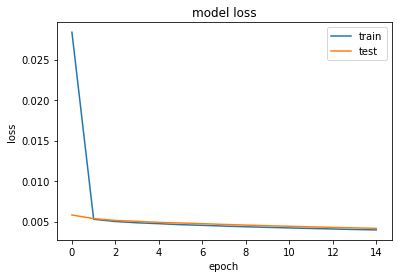

In [40]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="best")
plt.show()

In [41]:
def recommend_one(user_id, n=5):
    items_interacted = df[df.user_id == user_id]

    items_not_interacted = df[~df["item_id"].isin(items_interacted.item_id.values)]["item_id"]

    items_not_interacted = list(set(items_not_interacted).intersection(set(item2item_encoded.keys())))

    items_not_interacted = [[item2item_encoded.get(x)] for x in items_not_interacted]
    user_encoder = user2user_encoded.get(user_id)
    user_item_array = np.hstack(([[user_encoder]] * len(items_not_interacted), items_not_interacted))
    ratings = model.predict(user_item_array).flatten()

    top_ratings_indices = ratings.argsort()[-n:][::-1]

    return [item_encoded2item.get(items_not_interacted[x][0]) for x in top_ratings_indices]

In [43]:
def rule_nn(x, y):
      if x in y:
          return list([840361, 1029743, 995242, 981760, 1082185])
      else:
          return recommend_one(x, n=5)

In [59]:
uids_df = pd.DataFrame(data=x_train, columns=['user', 'item'])

In [60]:
uids = uids_df.user.apply(lambda x: userencoded2user[x]).tolist()
list_out_nn = result.loc[~result.user_id.isin(uids), 'user_id'].tolist()
list_out_nn

[]

In [61]:
result['NN'] = result['user_id'].apply(lambda x: rule_nn(x, list_out_nn))
map_k(result['NN'].values.tolist(), result['actual'].values.tolist())*100

KeyboardInterrupt: ignored